In [43]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm import tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

#  1.Fetch the data

In [3]:
sales = pd.read_csv('sales_train_evaluation.csv')
#sales.name = 'sales'
calendar = pd.read_csv('calendar.csv')
#calendar.name = 'calendar'
prices = pd.read_csv('sell_prices.csv')
#prices.name = 'prices'

### Since, the validation data is now available for the days 1914-1941, Adding zero sales for days: d_1942 - d_1969(Test)

In [4]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [5]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,0,0,0,0,0,0,0,0
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2.Downcasting

In [6]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  


In [7]:
sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [8]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,0,0,0,0,0,0,0,0
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3.Melting the data

In [9]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [10]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [11]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.980469
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.480469
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,3.980469
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,...,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,1.280273


# 4. Add more features

#### We are storing the categories correponding to their respective category codes so that we can use them later on while making the submission.

In [110]:
#Store the categories along with their codes  
d_id = dict(zip(sales.id.cat.codes, sales.id))
#d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
#d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
#d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(sales.store_id.cat.codes, sales.store_id))
#d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

## 4.1 Label Encoding
#### 1. Label Encode categorical features. (converted already converted categorical variable to category type to use their codes instead of using LableEncoder)
#### 2. Remove date as its features are already present.

In [12]:
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        

df.drop('date',axis=1,inplace=True)

In [13]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price'],
      dtype='object')

## 4.2 Lags

In [23]:
def create_features(df):
    lags = [7, 28]
    lag_cols = [f"sold_lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[['id','sold']].groupby('id').shift(lag).astype(np.float16)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[['id', lag_col]].groupby('id')[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)


In [24]:
create_features(df)

## 4.3 Mean Encoding

In [26]:
df['item_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)

In [27]:
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)

## 4.5 Save the data

### Lag and rolling window introduce a lot of Null values, so we will remove data for first 56 days as I have introduced lag till 28 days and rolling window of 28 days .

In [31]:
df = df[df['d']>=56]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58357860 entries, 1676950 to 60034809
Data columns (total 29 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int16  
 1   item_id               int16  
 2   dept_id               int8   
 3   cat_id                int8   
 4   store_id              int8   
 5   state_id              int8   
 6   d                     int16  
 7   sold                  int16  
 8   wm_yr_wk              int16  
 9   weekday               int8   
 10  wday                  int8   
 11  month                 int8   
 12  year                  int16  
 13  event_name_1          int8   
 14  event_type_1          int8   
 15  event_name_2          int8   
 16  event_type_2          int8   
 17  snap_CA               int8   
 18  snap_TX               int8   
 19  snap_WI               int8   
 20  sell_price            float16
 21  sold_lag_7            float16
 22  sold_lag_28           float16
 23 

In [33]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,snap_WI,sell_price,sold_lag_7,sold_lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,item_sold_avg,state_store_sold_avg
1676950,14370,1437,3,1,0,0,56,0,11108,0,...,0,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.216553,1.304688
1676951,14380,1438,3,1,0,0,56,0,11108,0,...,0,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.259766,1.304688
1676952,14390,1439,3,1,0,0,56,0,11108,0,...,0,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.076660,1.304688
1676953,14400,1440,3,1,0,0,56,1,11108,0,...,0,4.339844,0.0,0.0,0.142822,0.000000,0.178589,0.000000,2.011719,1.304688
1676954,14410,1441,3,1,0,0,56,0,11108,0,...,0,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.755371,1.304688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,14329,1432,2,0,9,2,1969,0,11621,3,...,0,2.980469,0.0,1.0,0.000000,0.571289,0.142822,0.643066,0.797852,1.089844
60034806,14339,1433,2,0,9,2,1969,0,11621,3,...,0,2.480469,0.0,0.0,0.000000,0.285645,0.071411,0.285645,0.430176,1.089844
60034807,14349,1434,2,0,9,2,1969,0,11621,3,...,0,3.980469,0.0,2.0,0.000000,0.856934,0.214233,0.785645,0.704102,1.089844
60034808,14359,1435,2,0,9,2,1969,0,11621,3,...,0,1.280273,0.0,0.0,0.000000,1.857422,0.464355,1.321289,0.637207,1.089844


In [34]:
df.fillna(0, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [35]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,snap_WI,sell_price,sold_lag_7,sold_lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,item_sold_avg,state_store_sold_avg
1676950,14370,1437,3,1,0,0,56,0,11108,0,...,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.216553,1.304688
1676951,14380,1438,3,1,0,0,56,0,11108,0,...,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.259766,1.304688
1676952,14390,1439,3,1,0,0,56,0,11108,0,...,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.076660,1.304688
1676953,14400,1440,3,1,0,0,56,1,11108,0,...,0,4.339844,0.0,0.0,0.142822,0.000000,0.178589,0.000000,2.011719,1.304688
1676954,14410,1441,3,1,0,0,56,0,11108,0,...,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.755371,1.304688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,14329,1432,2,0,9,2,1969,0,11621,3,...,0,2.980469,0.0,1.0,0.000000,0.571289,0.142822,0.643066,0.797852,1.089844
60034806,14339,1433,2,0,9,2,1969,0,11621,3,...,0,2.480469,0.0,0.0,0.000000,0.285645,0.071411,0.285645,0.430176,1.089844
60034807,14349,1434,2,0,9,2,1969,0,11621,3,...,0,3.980469,0.0,2.0,0.000000,0.856934,0.214233,0.785645,0.704102,1.089844
60034808,14359,1435,2,0,9,2,1969,0,11621,3,...,0,1.280273,0.0,0.0,0.000000,1.857422,0.464355,1.321289,0.637207,1.089844


In [36]:
df.to_pickle('finaldata2.pkl')
del df
gc.collect();

In [37]:
data = pd.read_pickle('finaldata2.pkl')
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [132]:
valid2 = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test2 = data[data['d']>=1942][['id','d','sold']]
eval_preds2 = test2['sold']
valid_preds2 = valid2['sold']

In [38]:
from lightgbm import LGBMRegressor

In [39]:
import joblib

### LightGBM fitting for each store

In [44]:
#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )

    print('*****Result for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model_lightgbm'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect() 
 

*****Result for Store: CA_1*****
[20]	training's rmse: 2.33909	training's l2: 5.47136	valid_1's rmse: 2.1083	valid_1's l2: 4.44491
[40]	training's rmse: 2.31159	training's l2: 5.34345	valid_1's rmse: 2.10675	valid_1's l2: 4.43839
*****Result for Store: CA_2*****
[20]	training's rmse: 1.7901	training's l2: 3.20445	valid_1's rmse: 1.95745	valid_1's l2: 3.8316
[40]	training's rmse: 1.7749	training's l2: 3.15028	valid_1's rmse: 1.9531	valid_1's l2: 3.81461
[60]	training's rmse: 1.76519	training's l2: 3.1159	valid_1's rmse: 1.95357	valid_1's l2: 3.81644
*****Result for Store: CA_3*****
[20]	training's rmse: 3.2951	training's l2: 10.8577	valid_1's rmse: 2.518	valid_1's l2: 6.34035
*****Result for Store: CA_4*****
[20]	training's rmse: 1.36252	training's l2: 1.85647	valid_1's rmse: 1.41525	valid_1's l2: 2.00293
[40]	training's rmse: 1.35472	training's l2: 1.83526	valid_1's rmse: 1.41336	valid_1's l2: 1.99759
[60]	training's rmse: 1.34981	training's l2: 1.82199	valid_1's rmse: 1.41278	valid_1'

### Feature importance

In [76]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']

In [77]:
for filename in os.listdir('/Users/zhouxiaomin/Desktop/hkust/COURSES NOTE/2021F/AI/Assignment3/'):
    if 'model_lightgbm' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[14:18]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)

In [73]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    plt.savefig('LightGBM feature importance20.png')


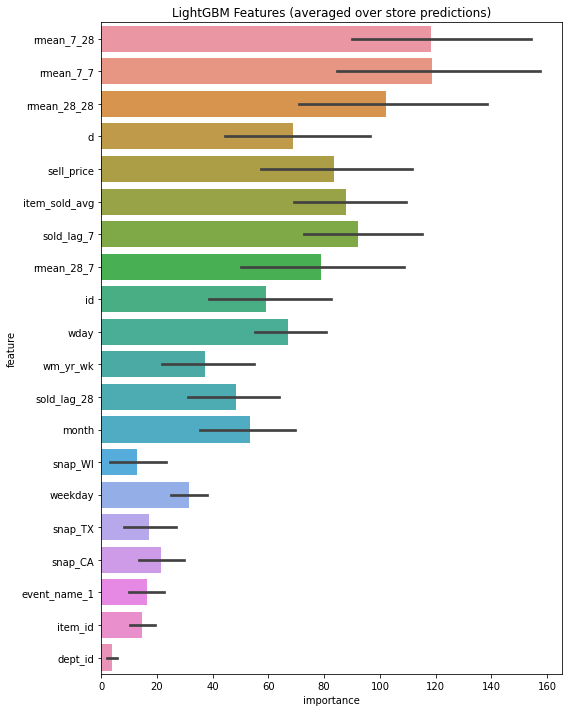

In [74]:
display_importances(feature_importance_df)

### Prediction

In [125]:
#Set actual equal to false if you want to top in the public leaderboard :P
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
    validation['id']=train_val.id
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
else:
    #Get the actual validation results
    valid['sold'] = valid_preds
    validation = valid[['id','d','sold']]
    validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit_2 = pd.concat([validation,evaluation]).reset_index(drop=True)
submit_2.to_csv('submission_truepredict.csv',index=False)

In [130]:
tttttt=pd.pivot(valid[['id','d','sold']], index='id', columns='d', values='sold').reset_index()
tttttt.id = tttttt.id.map(d_id).str.replace('evaluation','validation')
tttttt

d,id,1914,1915,1916,1917,1918,1919,1920,1921,1922,...,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
0,FOODS_1_001_CA_1_validation,1.142495,0.979554,0.979554,0.955764,1.124632,1.354340,1.358487,1.167306,1.014468,...,1.096283,1.250018,1.260512,0.984663,0.885547,0.837897,0.837897,0.912822,1.301521,1.215206
1,FOODS_1_001_CA_2_validation,1.162249,1.665484,1.271887,1.535840,1.550325,1.952053,1.701352,0.966333,1.185334,...,0.998394,1.356910,1.565754,0.858641,1.014576,0.970030,1.099173,1.019258,1.461374,1.234953
2,FOODS_1_001_CA_3_validation,1.332868,1.319077,1.319077,1.319077,1.180423,1.714863,0.921875,0.932192,0.856835,...,1.024279,1.077544,0.870871,0.831399,0.817607,0.817607,0.817607,0.839801,1.223564,0.985735
3,FOODS_1_001_CA_4_validation,0.476540,0.409494,0.425530,0.433012,0.463312,0.503810,0.562930,0.473710,0.446124,...,0.394920,0.454987,0.384279,0.401743,0.364728,0.346258,0.353740,0.410273,0.406259,0.399768
4,FOODS_1_001_TX_1_validation,0.224414,0.217026,0.217026,0.217026,0.183568,0.245822,0.231586,0.168520,0.161944,...,0.246031,0.542685,0.527993,0.376555,0.435126,0.360833,0.435126,0.459825,0.569008,0.620364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.271357,0.262853,0.363427,0.262853,0.272062,0.327537,0.309818,0.253638,0.245135,...,0.217504,0.346467,0.264284,0.216798,0.208295,0.208295,0.208295,0.217504,0.135913,0.135913
30486,HOUSEHOLD_2_516_TX_3_validation,0.154799,0.145118,0.145118,0.145118,0.151604,0.166493,0.183837,0.156092,0.157953,...,0.276569,0.175812,0.280354,0.226866,0.199074,0.199074,0.196358,0.185480,0.243478,0.206935
30487,HOUSEHOLD_2_516_WI_1_validation,0.085872,0.085872,0.089440,0.089440,0.074168,0.075189,0.089420,0.094676,0.092536,...,0.148298,0.329586,0.223797,0.156905,0.156905,0.160472,0.160472,0.167346,0.173077,0.165554
30488,HOUSEHOLD_2_516_WI_2_validation,0.074305,0.071987,0.071987,0.137852,0.141331,0.131437,0.147911,0.138128,0.130522,...,0.089207,0.068782,0.075342,0.074305,0.071987,0.071987,0.071987,0.088236,0.088399,0.166112


In [124]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,0,0,0,0,0,0,0,0
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
submit_2

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.142495,0.979554,0.979554,0.955764,1.124632,1.354340,1.358487,1.167306,1.014468,...,1.096283,1.250018,1.260512,0.984663,0.885547,0.837897,0.837897,0.912822,1.301521,1.215206
1,FOODS_1_001_CA_2_validation,1.162249,1.665484,1.271887,1.535840,1.550325,1.952053,1.701352,0.966333,1.185334,...,0.998394,1.356910,1.565754,0.858641,1.014576,0.970030,1.099173,1.019258,1.461374,1.234953
2,FOODS_1_001_CA_3_validation,1.332868,1.319077,1.319077,1.319077,1.180423,1.714863,0.921875,0.932192,0.856835,...,1.024279,1.077544,0.870871,0.831399,0.817607,0.817607,0.817607,0.839801,1.223564,0.985735
3,FOODS_1_001_CA_4_validation,0.476540,0.409494,0.425530,0.433012,0.463312,0.503810,0.562930,0.473710,0.446124,...,0.394920,0.454987,0.384279,0.401743,0.364728,0.346258,0.353740,0.410273,0.406259,0.399768
4,FOODS_1_001_TX_1_validation,0.224414,0.217026,0.217026,0.217026,0.183568,0.245822,0.231586,0.168520,0.161944,...,0.246031,0.542685,0.527993,0.376555,0.435126,0.360833,0.435126,0.459825,0.569008,0.620364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_TX_2_evaluation,0.173998,0.144320,0.144320,0.144320,0.153528,0.182590,0.245652,0.152823,0.144320,...,0.106851,0.135913,0.135913,0.106146,0.097642,0.097642,0.097642,0.106851,0.135913,0.135913
60976,HOUSEHOLD_2_516_TX_3_evaluation,0.188675,0.178994,0.178994,0.178994,0.222024,0.289938,0.432262,0.347155,0.296699,...,0.152898,0.180651,0.180651,0.166340,0.145118,0.156659,0.145118,0.151604,0.164601,0.205597
60977,HOUSEHOLD_2_516_WI_1_evaluation,0.134760,0.134760,0.138328,0.138328,0.176149,0.246158,0.220549,0.148555,0.156905,...,0.145201,0.105293,0.097769,0.070392,0.063727,0.070392,0.067295,0.074168,0.102045,0.067666
60978,HOUSEHOLD_2_516_WI_2_evaluation,0.146429,0.118822,0.118822,0.118822,0.141331,0.164129,0.147083,0.066896,0.071987,...,0.100621,0.092388,0.075342,0.075276,0.070329,0.071301,0.071987,0.088236,0.111034,0.086578


In [123]:
submit

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,5.000000,0.000000,0.000000,...,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,1.000000
1,HOBBIES_1_002_CA_1_validation,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,HOBBIES_1_003_CA_1_validation,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,1.000000
3,HOBBIES_1_004_CA_1_validation,0.000000,0.000000,1.000000,2.000000,4.000000,1.000000,6.000000,4.000000,0.000000,...,1.000000,1.000000,0.000000,4.000000,0.000000,1.000000,3.000000,0.000000,2.000000,6.000000
4,HOBBIES_1_005_CA_1_validation,1.000000,0.000000,2.000000,3.000000,1.000000,0.000000,3.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_TX_2_evaluation,0.173998,0.144320,0.144320,0.144320,0.153528,0.182590,0.245652,0.152823,0.144320,...,0.106851,0.135913,0.135913,0.106146,0.097642,0.097642,0.097642,0.106851,0.135913,0.135913
60976,HOUSEHOLD_2_516_TX_3_evaluation,0.188675,0.178994,0.178994,0.178994,0.222024,0.289938,0.432262,0.347155,0.296699,...,0.152898,0.180651,0.180651,0.166340,0.145118,0.156659,0.145118,0.151604,0.164601,0.205597
60977,HOUSEHOLD_2_516_WI_1_evaluation,0.134760,0.134760,0.138328,0.138328,0.176149,0.246158,0.220549,0.148555,0.156905,...,0.145201,0.105293,0.097769,0.070392,0.063727,0.070392,0.067295,0.074168,0.102045,0.067666
60978,HOUSEHOLD_2_516_WI_2_evaluation,0.146429,0.118822,0.118822,0.118822,0.141331,0.164129,0.147083,0.066896,0.071987,...,0.100621,0.092388,0.075342,0.075276,0.070329,0.071301,0.071987,0.088236,0.111034,0.086578
